In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
from scipy.stats import sem
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import glob as g
import re
import mdtraj as md
import seaborn as sns
import time
from io import StringIO
plt.rcParams["figure.dpi"] = (150)


In [2]:
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd']
colors_nine = ['#1f77b4','#1f77b4','#1f77b4','#2ca02c','#2ca02c','#2ca02c','#ff7f0e','#ff7f0e','#ff7f0e']
color_palette = {
    'wat': '#1f77b4',
    'phe': '#ff7f0e',
    'bza': '#2ca02c',
    'unk1': '#d62728',
    'unk2': '#9467bd'
}

In [3]:
#path where the simulations are:
#path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped'
#path = '/lrlhps/users/l034064/TZP/Pep706/Tri_Lys20_neutral_250ns_20x'
path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'
folder = [ 'desmond_md_job_wat_merged_water', 'desmond_md_job_bza_merged_water', 'desmond_md_job_phe_60_merged_water']


paths_md = []
paths_agg = []
for d in folder:
    aux_md = g.glob('{}/{}'.format(path,d))
#    aux_agg = g.glob('{}/{}/all_frames_ligand'.format(path,d))
    
    paths_md.append(aux_md[0])
#    paths_agg.append(aux_agg[0])


In [4]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
# Define the colors for the colormap: green, white, and orange
colors_int = [(1, 1, 1), (1, 0, 0)]

# Define the positions for the colors
positions = [0, 1]

# Create the colormap
cmap_2 = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_int)))

colors_phe = [(1, 1, 1), '#ff7f0e']
colors_bza = [(1, 1, 1), '#2ca02c']
colors_wat = [(1, 1, 1), '#1f77b4']

# Create the colormap
cmap_phe = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_phe)))
cmap_bza = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_bza)))
cmap_wat = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_wat)))

In [5]:
# Define the colors for the colormap: green, white, and orange
color_map_wat_phe = ['#1f77b4', (1, 1, 1) ,'#ff7f0e']
color_map_wat_bza = ['#1f77b4', (1, 1, 1) ,'#2ca02c']
color_map_bza_phe = ['#2ca02c', (1, 1, 1) ,'#ff7f0e']

'#2ca02c','#ff7f0e'

# Define the positions for the colors
positions = [0, 0.5, 1]

# Create the colormap
cmap_wat_phe = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, color_map_wat_phe)))
cmap_wat_bza = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, color_map_wat_bza)))
cmap_bza_phe = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, color_map_bza_phe)))


In [6]:
TZP_seq = ['TYR_1',
 'AIB_2',
 'GLU_3',
 'GLY_4',
 'THR_5',
 'PHE_6',
 'THR_7',
 'SER_8',
 'ASP_9',
 'TYR_10',
 'SER_11',
 'ILE_12',
 'AIB_13',
 'LEU_14',
 'ASP_15',
 'LYS_16',
 'ILE_17',
 'ALA_18',          
 'GLN_19',
 'LYS_20',
 'ALA_21',
 'PHE_22',          
 'VAL_23',
 'GLN_24',
 'TRP_25',
 'LEU_26',
 'ILE_27',
 'ALA_28',
 'GLY_29',
 'GLY_30',
 'PRO_31',
 'SER_32',
 'SER_33',
 'GLY_34',
 'ALA_35',
 'PRO_36',
 'PRO_37',
 'PRO_38',
 'SER_39']

# Create a DataFrame with 39 rows and Resid values from TZP_seq
resid_df = pd.DataFrame({'Resid': TZP_seq,'Resid_number': range(1, 40)})

In [7]:
chains = ['A','B','C']
systems = ['Non-Pres','Bza','Phe']
res_num = 39
hb = []
hyd = []
polar = []
water = []

for i,s in enumerate(folder):
    name = systems[i] 
    hb_aux = pd.DataFrame()
    hyd_aux = pd.DataFrame()
    polar_aux = pd.DataFrame()
    water_aux = pd.DataFrame()
    for c in chains:
        hbond_sections = {}
        hydrophobic_sections = {}
        pi_pi_sections = {}
        pi_cat_sections = {}
        polar_sections = {}
        water_sections = {}
        # Open the file and read line by line
        file = path+'/'+ s +'/'+'prot_FA_{}-out-ProtLigandInter.csv'.format(c)
        with open(file, "r") as file:
            current_section = None
            for line in file:
                if line.startswith("#HBondResult"):
                    current_section = hbond_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#HydrophobicResult"):
                    current_section = hydrophobic_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#PiPiResult"):
                    current_section = pi_pi_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#PiCatResult"):
                    current_section = pi_cat_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#PolarResult"):
                    current_section = polar_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#WaterBridgeResult"):    #WaterBridgeResult
                    current_section = water_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif current_section is not None:
                    current_section["data"].append(line.strip())

        #print(hbond_sections)
        # Convert sections to DataFrames
        hbond_df = pd.read_csv(StringIO("\n".join(hbond_sections["data"])))
        hbond_merged_df = pd.concat([hbond_df, hb_aux], ignore_index=True)
        hb_aux = hbond_merged_df

        hydrophobic_df = pd.read_csv(StringIO("\n".join(hydrophobic_sections["data"])))
        hyd_merged_df = pd.concat([hydrophobic_df, hyd_aux], ignore_index=True)
        hyd_aux = hyd_merged_df

        polar_df = pd.read_csv(StringIO("\n".join(polar_sections["data"])))
        polar_merged_df = pd.concat([polar_df, polar_aux], ignore_index=True)
        polar_aux = polar_merged_df
        
        water_df = pd.read_csv(StringIO("\n".join(water_sections["data"])))
        water_merged_df = pd.concat([water_df, water_aux], ignore_index=True)
        water_aux = water_merged_df

        
    hb.append(hbond_merged_df) 
    hyd.append(hyd_merged_df) 
    polar.append(polar_merged_df) 
    water.append(water_merged_df)

In [8]:
hyd[0]

,Residue/Ligand Interaction Name,Fragment Atom #,Total Number,Relative Occurence (%)
0,A:ALA_18:L-FRAG_10,"1694, 1695, 2044, 2045, 2046, 2047",11,0.27
1,A:ALA_18:L-FRAG_12,"1697, 1698, 2048, 2049, 2050, 2051",20,0.50
2,A:ALA_18:L-FRAG_14,"1700, 1701, 1702, 2052, 2053",6,0.15
3,A:ALA_35:L-FRAG_0,"1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668...",4,0.10
4,A:ILE_12:L-FRAG_10,"1694, 1695, 2044, 2045, 2046, 2047",32,0.80
...,...,...,...,...
487,C:TYR_1:L-FRAG_0,"289, 290, 291, 292, 293, 294, 295, 296, 297, 2...",22,0.55
488,C:TYR_1:L-FRAG_2,"307, 308, 309, 310, 311, 332, 333, 334, 655, 6...",9,0.22
489,C:TYR_1:L-FRAG_4,"313, 314, 661, 662, 663, 664",6,0.15
490,C:TYR_1:L-FRAG_6,"316, 317, 665, 666, 667, 668",1,0.02


In [9]:
def filter_int(df_a,df_b,df_c,resid_df):
    # Filter rows where Resid_chain is 'A'
    # Group by Resid and FA and sum the values of Relative Occurrence (%)
    df_a_grouped = df_a.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_b_grouped = df_b.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_c_grouped = df_c.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
               
    # Extract numerical part from "Resid" string and convert to integer
    df_a_grouped['Resid_number'] = df_a_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_b_grouped['Resid_number'] = df_b_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_c_grouped['Resid_number'] = df_c_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    
    # Merge resid_df with your original DataFrame on 'Resid' using a left join to keep all Resid values
    merged_df_A = pd.merge(resid_df, df_a_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_B = pd.merge(resid_df, df_b_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_C = pd.merge(resid_df, df_c_grouped, on=['Resid', 'Resid_number'], how='left')
    
    # Fill missing values with 0 for 'Relative Occurrence (%)'
    merged_df_A['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_B['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_C['Relative Occurence (%)'].fillna(0, inplace=True)

    # Reorder columns if needed
    merged_df_A = merged_df_A[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_B = merged_df_B[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_C = merged_df_C[['Resid', 'Relative Occurence (%)', 'Resid_number']]

    # Sort the DataFrame by "Resid_number"
    df_sorted_A = merged_df_A.sort_values('Resid_number')
    df_sorted_B = merged_df_B.sort_values('Resid_number')
    df_sorted_C = merged_df_C.sort_values('Resid_number')
    # Filter df_a_grouped by occurrence higher than 5
    df_filtered_A = df_sorted_A[df_sorted_A['Relative Occurence (%)'] >= 0.0]
    df_filtered_B = df_sorted_B[df_sorted_B['Relative Occurence (%)'] >= 0.0]
    df_filtered_C = df_sorted_C[df_sorted_C['Relative Occurence (%)'] >= 0.0]

    df_filtered_A.reset_index(drop=True, inplace=True)
    df_filtered_B.reset_index(drop=True, inplace=True)
    df_filtered_C.reset_index(drop=True, inplace=True)
    return(df_filtered_A,df_filtered_B,df_filtered_C)

In [10]:
hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]

/node/scratch/139351321.1.all.normal.q/ipykernel_886/2942866490.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]


,1,0,3
0,GLN_24,C,L-FRAG_14
1,PRO_31,B,L-FRAG_3
2,GLN_24,C,L-FRAG_8
3,GLN_24,C,L-FRAG_0
4,SER_39,B,L-FRAG_14
...,...,...,...
267,SER_33,C,L-FRAG_1
268,SER_33,C,L-FRAG_2
269,SER_39,C,L-FRAG_0
270,SER_32,B,L-FRAG_2


In [11]:
hbond_df

,Residue/Ligand Interaction Name,Backbone/Side Chain,Fragment Atom #,Atom Name,Atoms #,Total Number,Relative Occurence (%)
0,C:GLN_24:S:L-FRAG_14,S,"1700, 1701, 1702, 2052, 2053",O5,1702,191,4.75
1,B:PRO_31:B:L-FRAG_3,B,"1684, 2032",HN1,2032,154,3.83
2,C:GLN_24:S:L-FRAG_8,S,"1691, 1692, 1703, 2041, 2042",O6,1703,141,3.51
3,C:GLN_24:S:L-FRAG_0,S,"1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668...",O9,1707,152,3.78
4,B:SER_39:S:L-FRAG_14,S,"1700, 1701, 1702, 2052, 2053",O5,1702,114,2.84
...,...,...,...,...,...,...,...
267,C:SER_33:B:L-FRAG_1,B,"1677, 2024",HN,2024,1,0.02
268,C:SER_33:B:L-FRAG_2,B,"1679, 1680, 1681, 1682, 1683, 1704, 1705, 1706...",O7,1705,1,0.02
269,C:SER_39:B:L-FRAG_0,B,"1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668...",O312,1711,1,0.02
270,B:SER_32:B:L-FRAG_2,B,"1679, 1680, 1681, 1682, 1683, 1704, 1705, 1706...",O7,1705,1,0.02


In [12]:
hb_final = []
hb_raw = []
hyd_final = []
polar_final = []
pipi_final = []
picat_final = []
water_final = []
for i in range(len(systems)):
    hbond_df = hb[i]
    hyd_df = hyd[i]
    polar_df = polar[i]
    water_df = water[i]
    #HBOND    
    hbond_df[['Resid','Resid_chain', 'Lig']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
    df_a = hbond_df[hbond_df['Resid_chain'] == 'A']
    df_b = hbond_df[hbond_df['Resid_chain'] == 'B']
    df_c = hbond_df[hbond_df['Resid_chain'] == 'C']
    
    hb_raw.append([df_a,df_b,df_c])
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    hb_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #HYDROPHOBIC
    hyd_df[['Resid','Resid_chain', 'Lig']] = hyd_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
    df_a = hyd_df[hyd_df['Resid_chain'] == 'A']
    df_b = hyd_df[hyd_df['Resid_chain'] == 'B']
    df_c = hyd_df[hyd_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    hyd_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #POLAR
    polar_df = polar[i]
    polar_df[['Resid','Resid_chain', 'FA']] = polar_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
    df_a = polar_df[polar_df['Resid_chain'] == 'A']
    df_b = polar_df[polar_df['Resid_chain'] == 'B']
    df_c = polar_df[polar_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    polar_final.append([df_filtered_A,df_filtered_B,df_filtered_C])

    #PIPI
#    pipi_df[['Resid','Resid_chain', 'Lig']] = pipi_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
#    df_a = pipi_df[pipi_df['Resid_chain'] == 'A']
#    df_b = pipi_df[pipi_df['Resid_chain'] == 'B']
#    df_c = pipi_df[pipi_df['Resid_chain'] == 'C']
 
#    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
#    pipi_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #PICAT
#    picat_df[['Resid','Resid_chain', 'Lig']] = picat_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
#    df_a = picat_df[picat_df['Resid_chain'] == 'A']
#    df_b = picat_df[picat_df['Resid_chain'] == 'B']
#    df_c = picat_df[picat_df['Resid_chain'] == 'C']
 
#    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
#    picat_final.append([df_filtered_A,df_filtered_B,df_filtered_C])    
    
    #WATER
    water_df[['Resid','Resid_chain', 'Lig']] = water_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
    df_a = water_df[water_df['Resid_chain'] == 'A']
    df_b = water_df[water_df['Resid_chain'] == 'B']
    df_c = water_df[water_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    water_final.append([df_filtered_A,df_filtered_B,df_filtered_C])    
    
#    hyd_df = hyd_merged_df
#    hyd_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]

/node/scratch/139351321.1.all.normal.q/ipykernel_886/1556349579.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hbond_df[['Resid','Resid_chain', 'Lig']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
/node/scratch/139351321.1.all.normal.q/ipykernel_886/1556349579.py:25: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hyd_df[['Resid','Resid_chain', 'Lig']] = hyd_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
/node/scratch/139351321.1.all.normal.q/ipykernel_886/1556349579.py:35: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  polar_df[['Resid','Resid_chain', 'FA']] = polar_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]


In [13]:
chains = ['A','B','C']
combined_df = []
for i,s in enumerate(systems):
    for j,c in enumerate(chains):
        df1 = hb_final[i][j]
        df2 = hyd_final[i][j]
        df4 = polar_final[i][j]
        df5 = water_final[i][j]
        df1['Int.'] = 'Hbond'
        df2['Int.'] = 'Hydrophobic'
        df4['Int.'] = 'Polar'
        df5['Int.'] = 'Water Bridge'
        
        df1['Sys'] = s
        df2['Sys'] = s
        df4['Sys'] = s
        df5['Sys'] = s
        
        
        df1['Chain'] = c
        df2['Chain'] = c
        df4['Chain'] = c
        df5['Chain'] = c
        
        combined_df.append(pd.concat([df1, df2, df4, df5]))

# Combine all DataFrames into a single DataFrame
final_combined_df = pd.concat(combined_df,ignore_index=True)

In [14]:
final_df = final_combined_df

In [15]:
final_df

,Resid,Relative Occurence (%),Resid_number,Int.,Sys,Chain
0,TYR_1,8.82,1,Hbond,Non-Pres,A
1,AIB_2,2.11,2,Hbond,Non-Pres,A
2,GLU_3,0.79,3,Hbond,Non-Pres,A
3,GLY_4,0.60,4,Hbond,Non-Pres,A
4,THR_5,3.27,5,Hbond,Non-Pres,A
...,...,...,...,...,...,...
1399,ALA_35,3.70,35,Water Bridge,Phe,C
1400,PRO_36,3.01,36,Water Bridge,Phe,C
1401,PRO_37,5.07,37,Water Bridge,Phe,C
1402,PRO_38,4.52,38,Water Bridge,Phe,C


In [16]:
int_values = final_df['Int.'].unique()

In [18]:
unique_resid = final_df['Resid'].unique()

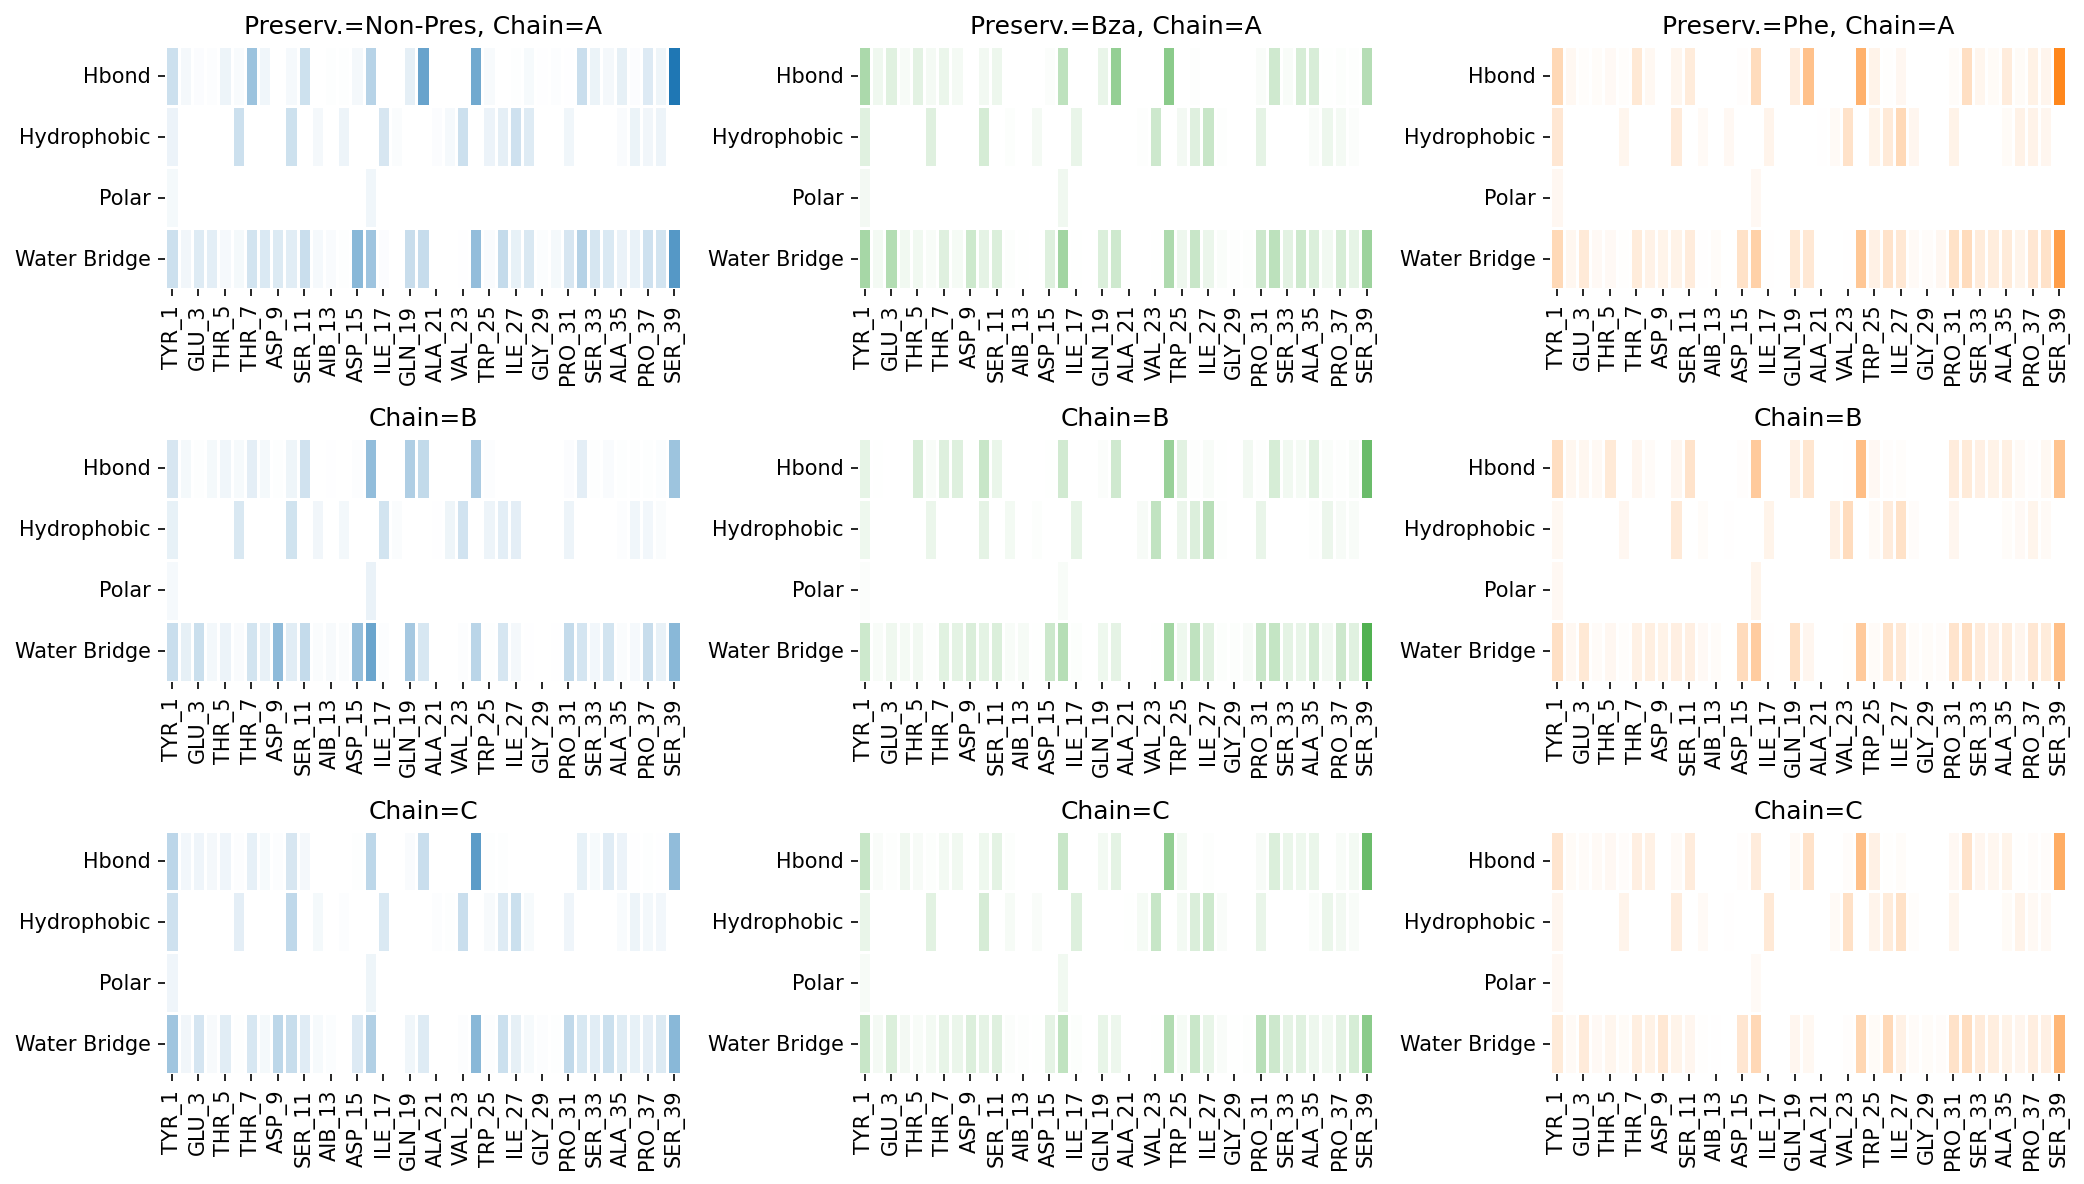

In [19]:
# Filter the DataFrame for rows where 'Sys' is 'Bza' and 'Chain' is 'A'
vmax = final_df['Relative Occurence (%)'].max()
vmin = 0
unique_int_values = final_df['Int.'].unique()
# Define the combinations of 'Sys', 'Chain', and 'Int.' values
sys_values = ['Non-Pres','Bza', 'Phe']
chain_values = ['A', 'B', 'C']

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(14, 8))

# Iterate over combinations of 'Sys', 'Chain', and 'Int.' values
for i, sys in enumerate(sys_values):
    for j, chain in enumerate(chain_values):
        # Filter the DataFrame for the current combination of 'Sys' and 'Chain'
        filtered_df = final_df[(final_df['Sys'] == sys) & (final_df['Chain'] == chain)]
        
        # Filter the DataFrame for the current 'Int.' value and pivot the data
        for k, int_value in enumerate(int_values):
            heatmap_data = filtered_df.pivot(index='Int.', columns='Resid', values='Relative Occurence (%)')
            if sys == 'Non-Pres':
                cmap = cmap_wat
            elif sys == 'Bza':
                cmap = cmap_bza
            elif sys == 'Phe':
                cmap = cmap_phe
            # Plot the heatmap
            heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap, linewidths=0.5, ax=axs[j, i], cbar=False,vmin=vmin, vmax=vmax)
            heatmap.set_xlabel('')
            heatmap.set_ylabel('')
            if chain == 'A':
                heatmap.set_title(f'Preserv.={sys}, Chain={chain}')
            else:
                heatmap.set_title(f'Chain={chain}')

# Add colorbar to the last plot
#

plt.tight_layout()
plt.show()

In [21]:
# Calculate the mean of 'Relative Occurrence (%)' for each unique combination of 'Sys' and 'Int.'
means_per_resid = final_combined_df.groupby(['Sys','Resid', 'Int.','Resid_number'])['Relative Occurence (%)'].mean()
# Convert the result to a DataFrame
mean_occurrence_df = means_per_resid.reset_index()

# Pivot the DataFrame
pivot_df = mean_occurrence_df.groupby(['Resid', 'Int.', 'Resid_number', 'Sys'])['Relative Occurence (%)'].mean().unstack()

# Calculate the difference between 'phe' and 'bza' systems for each 'Resid'
pivot_df['difference'] = pivot_df['Bza'] - pivot_df['Non-Pres']

# Reset index to convert the result to a DataFrame
difference_df = pivot_df.reset_index()

In [22]:
pivot_df['difference'].max()

3.256666666666667

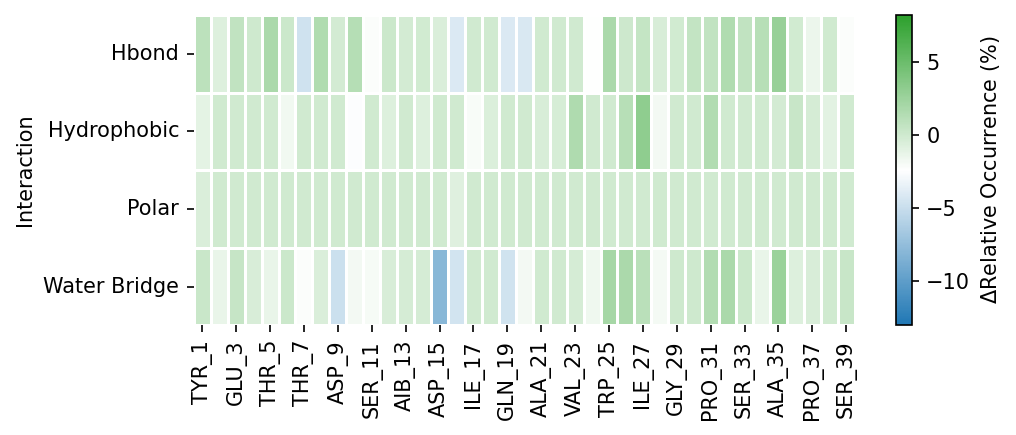

In [24]:
vmin = pivot_df['difference'].min() -5
vmax = pivot_df['difference'].max() +5

heatmap_data = difference_df.pivot(index='Int.', columns='Resid', values='difference')

# Create the heatmap
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap_wat_bza, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False)

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_wat_bza, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'$\Delta$Relative Occurrence (%)')

plt.tight_layout()
plt.show()

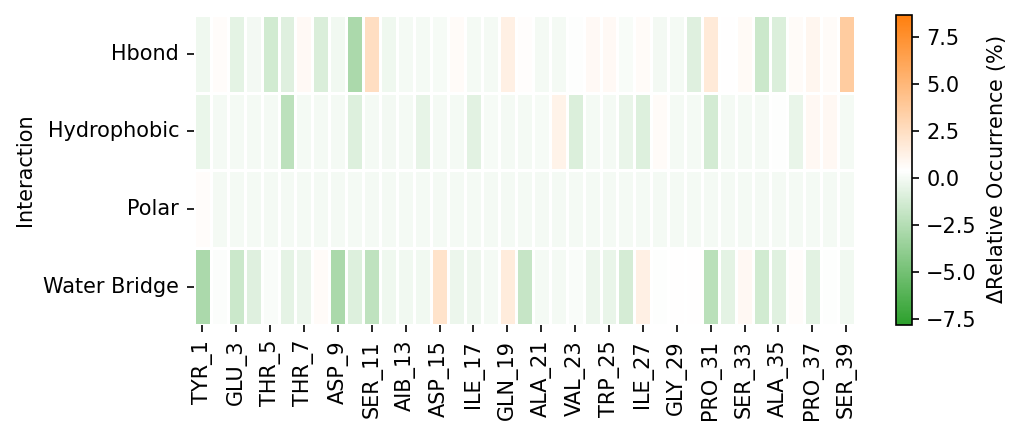

In [26]:
# Calculate the difference between 'phe' and 'bza' systems for each 'Resid'
pivot_df['difference'] = pivot_df['Phe'] - pivot_df['Bza']
vmin = pivot_df['difference'].min() -5
vmax = pivot_df['difference'].max() +5
# Reset index to convert the result to a DataFrame
difference_df = pivot_df.reset_index()

heatmap_data = difference_df.pivot(index='Int.', columns='Resid', values='difference')

# Create the heatmap
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap_bza_phe, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False)

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_bza_phe, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'$\Delta$Relative Occurrence (%)')

plt.tight_layout()
plt.show()

In [27]:
sum_int = final_combined_df.groupby(['Sys','Chain','Resid_number','Int.'])['Relative Occurence (%)'].sum()
sum_int_df = sum_int.reset_index()

/node/scratch/139351321.1.all.normal.q/ipykernel_886/92593450.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=sum_occurrence, x='Sys', y='Relative Occurence (%)', hue='Chain', ci='sd', capsize=0.1, errwidth=1, errcolor='black')


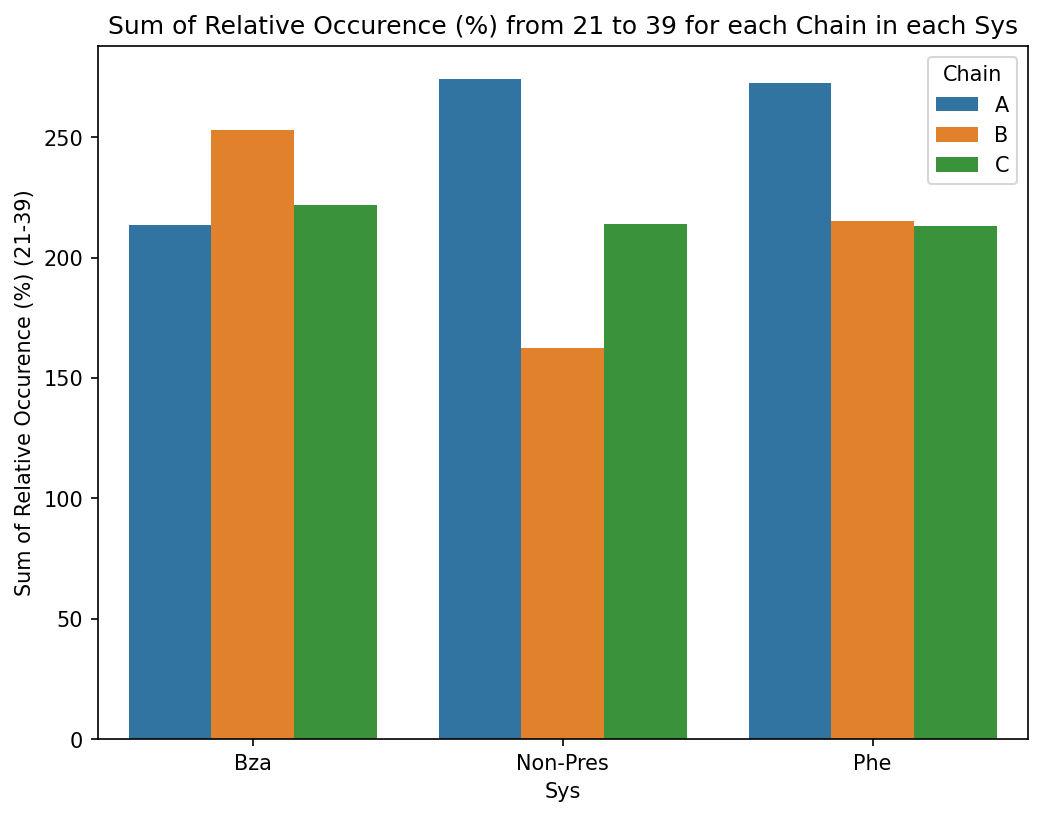

In [28]:
colors_chains = ['#1f77b4','#1f77b4','#1f77b4','#2ca02c','#2ca02c','#2ca02c','#ff7f0e','#ff7f0e','#ff7f0e']

# Filter the DataFrame for Resid_number from 21 to 39
#filtered_df = sum_int_df[(sum_int_df['Resid_number'].isin([25]))]
filtered_df = sum_int_df[(sum_int_df['Resid_number'] >= 21) & (sum_int_df['Resid_number'] <= 39)]
#filtered_df = filtered_df[(filtered_df['Int.'] == 'Hydrophobic')]
#filtered_df = filtered_df[(filtered_df['Sys'] == 'Non-Pres')]
# Calculate the sum of Relative Occurrence (%) for each Chain in each Sys
sum_occurrence = filtered_df.groupby(['Sys', 'Chain'])['Relative Occurence (%)'].sum().reset_index()
sem_occurrence = filtered_df.groupby(['Sys', 'Chain'])['Relative Occurence (%)'].sem().reset_index()

# Plot a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=sum_occurrence, x='Sys', y='Relative Occurence (%)', hue='Chain', ci='sd', capsize=0.1, errwidth=1, errcolor='black')
# Set labels and title
plt.xlabel('Sys')
plt.ylabel('Sum of Relative Occurence (%) (21-39)')
plt.title('Sum of Relative Occurence (%) from 21 to 39 for each Chain in each Sys')
plt.legend(title='Chain')
#plt.ylim(6,8)
plt.show()

In [86]:
sum_occurrence

,Sys,Chain,Relative Occurence (%)
0,Bza,A,5.63
1,Bza,B,11.96
2,Bza,C,6.31
3,Non-Pres,A,6.03
4,Non-Pres,B,4.16
5,Non-Pres,C,2.21
6,Phe,A,11.23
7,Phe,B,4.73
8,Phe,C,8.89


In [29]:
# Assuming final_df is your DataFrame
final_df = final_combined_df
# Calculate the average 'Relative Occurrence (%)' for 'Whole pep.'
whole_pep_avg = final_df.groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
whole_pep_avg.rename(columns={'Relative Occurence (%)': 'Whole pep.'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 1-20
resid_1_to_20_avg = final_df[final_df['Resid_number'].between(1, 20)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_1_to_20_avg.rename(columns={'Relative Occurence (%)': 'Resid. 1-20'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 21-39
resid_21_to_39_avg = final_df[final_df['Resid_number'].between(21, 39)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_21_to_39_avg.rename(columns={'Relative Occurence (%)': 'Resid. 21-39'}, inplace=True)

# Merge the average values into a new DataFrame
new_df = whole_pep_avg.merge(resid_1_to_20_avg, on=['Int.', 'Sys'], how='outer').merge(resid_21_to_39_avg, on=['Int.', 'Sys'], how='outer')

# Print or further process the new_df DataFrame
print(new_df)

            Int.       Sys  Whole pep.  Resid. 1-20  Resid. 21-39
0          Hbond       Bza      400.30       188.03        212.27
1          Hbond  Non-Pres      432.88       230.96        201.92
2          Hbond       Phe      421.64       185.47        236.17
3    Hydrophobic       Bza      204.52        71.95        132.57
4    Hydrophobic  Non-Pres      220.66       100.00        120.66
5    Hydrophobic       Phe      189.19        57.77        131.42
6          Polar       Bza       11.65        11.65          0.00
7          Polar  Non-Pres       15.70        15.70          0.00
8          Polar       Phe       13.30        13.30          0.00
9   Water Bridge       Bza      610.30       266.60        343.70
10  Water Bridge  Non-Pres      694.54       366.61        327.93
11  Water Bridge       Phe      569.60       236.48        333.12


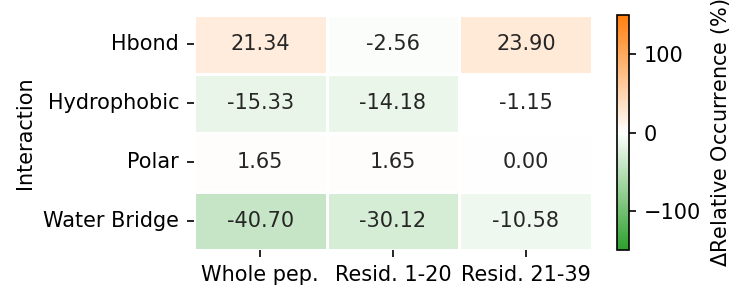

In [30]:
vmax = 150
vmin = -150

# Get unique values in the 'Int.' column
unique_int_values = new_df['Int.'].unique()

# Initialize an empty DataFrame to store the differences
difference_df = pd.DataFrame(index=unique_int_values)

# Filter the DataFrame for 'Phe' and 'Bza' interactions
for int_value in unique_int_values:
    wat_values = new_df[(new_df['Sys'] == 'Non-Pres') & (new_df['Int.'] == int_value)]
    phe_values = new_df[(new_df['Sys'] == 'Phe') & (new_df['Int.'] == int_value)]
    bza_values = new_df[(new_df['Sys'] == 'Bza') & (new_df['Int.'] == int_value)]
    
    # Calculate the differences between the columns for 'Phe' and 'Bza'
    difference_cols = ['Whole pep.', 'Resid. 1-20', 'Resid. 21-39']
    for col in difference_cols:
        difference_col = col
        difference_df.loc[int_value, difference_col] = phe_values[col].values - bza_values[col].values

# Plot the heatmap
plt.figure(figsize=(5, 2.1))
heatmap = sns.heatmap(difference_df, cmap=cmap_bza_phe, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False, annot=True, fmt=".2f")

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_bza_phe, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'$\Delta$Relative Occurrence (%)')

plt.tight_layout()
plt.show()

In [148]:
hb_raw[0][0]

,Residue/Ligand Interaction Name,Backbone/Side Chain,Fragment Atom #,Atom Name,Atoms #,Total Number,Relative Occurence (%),Resid,Resid_chain,Lig
3,A:THR_7:S:L-FRAG_2,S,"1679, 1680, 1681, 1682, 1683, 1704, 1705, 1706...",O8,1706,314,7.81,THR_7,A,L-FRAG_2
6,A:THR_7:B:L-FRAG_2,B,"1679, 1680, 1681, 1682, 1683, 1704, 1705, 1706...",O8,1706,240,5.97,THR_7,A,L-FRAG_2
13,A:ASP_15:S:L-FRAG_3,S,"1684, 2032",HN1,2032,58,1.44,ASP_15,A,L-FRAG_3
15,A:THR_7:S:L-FRAG_8,S,"1691, 1692, 1703, 2041, 2042",O6,1703,57,1.42,THR_7,A,L-FRAG_8
20,A:SER_11:S:L-FRAG_9,S,"1693, 2043",HN2,2043,39,0.97,SER_11,A,L-FRAG_9
...,...,...,...,...,...,...,...,...,...,...
721,A:SER_33:S:L-FRAG_2,S,"307, 308, 309, 310, 311, 332, 333, 334, 655, 6...",O8,334,1,0.02,SER_33,A,L-FRAG_2
722,A:ALA_28:B:L-FRAG_9,B,"321, 671",HN2,671,1,0.02,ALA_28,A,L-FRAG_9
725,A:THR_7:S:L-FRAG_14,S,"328, 329, 330, 680, 681",O5,330,1,0.02,THR_7,A,L-FRAG_14
726,A:VAL_23:B:L-FRAG_9,B,"321, 671",HN2,671,1,0.02,VAL_23,A,L-FRAG_9


In [147]:
categories = ['Non-P._A','Non-P._B','Non-P._C','Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Define the ranges of residues
#df_hb = hb_raw

Nter = range(1, 21)
Cter = range(21, 40)

sums_all = []
sums_Nter = []
sums_Cter = []

sem_all = []
sem_Nter = []
sem_Cter = []

chain_tick = []
for i in range(len(systems)):
    for j, c in enumerate(chains):
        df_hb = hb_raw[i][j]
        sums_all.append(df_hb['Relative Occurence (%)'].sum()/res_num)
        sums_Nter.append(df_hb[df_hb['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sum()/len(Nter))
        sums_Cter.append(df_hb[df_hb['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sum()/len(Cter))
        
        sem_all.append(df_hb['Relative Occurence (%)'].sem()/4)
        sem_Nter.append(df[df['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sem()/3)
        sem_Cter.append(df[df['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sem()/2)
        
        chain_tick.append(c)
# Plot the sums using a bar plot
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

axes[0].bar(range(1, 10), sums_all, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_all,capsize=3)
axes[0].set_xlabel('')
axes[0].set_title('Whole Pep')
axes[0].set_ylim(2,5.5)
axes[0].set_ylabel('<FA/Pep Hbond Occurences>')
axes[0].set_xticks(range(1, 10),categories, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(range(1, 10), sums_Nter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Nter,capsize=3)
axes[1].set_xlabel('')
axes[1].set_title('Res. 1-20')
axes[1].set_ylim(2,5.5)
axes[1].set_xticks(range(1, 10),categories, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].bar(range(1, 10), sums_Cter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Cter,capsize=3)
axes[2].set_xlabel('')
axes[2].set_title('Res. 21-39')
axes[2].set_ylim(2,5.5)
axes[2].set_xticks(range(1, 10),categories, rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


KeyError: 'Resid_number'

In [125]:
categories = ['Non-P._A','Non-P._B','Non-P._C','Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Define the ranges of residues
Nter = range(1, 21)
Cter = range(21, 40)

sums_all = []
sums_Nter = []
sums_Cter = []

sem_all = []
sem_Nter = []
sem_Cter = []

chain_tick = []
for i in range(len(system)):
    for j, c in enumerate(chains):
        df_hb = hyd_final[i][j]
        sums_all.append(df_hb['Relative Occurence (%)'].sum()/res_num)
        sums_Nter.append(df_hb[df_hb['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sum()/len(Nter))
        sums_Cter.append(df_hb[df_hb['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sum()/len(Cter))
        
        sem_all.append(df_hb['Relative Occurence (%)'].sem()/2)
        sem_Nter.append(df[df['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sem()/2)
        sem_Cter.append(df[df['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sem()/2)
        
        chain_tick.append(c)
# Plot the sums using a bar plot
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

axes[0].bar(range(1, 10), sums_all, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_all,capsize=3)
axes[0].set_xlabel('')
axes[0].set_title('Whole Pep')
axes[0].set_ylim(0,3)
axes[0].set_ylabel('<FA/Pep Hyd. Int.  Occurences>')
axes[0].set_xticks(range(1, 10),categories, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(range(1, 10), sums_Nter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Nter,capsize=3)
axes[1].set_xlabel('')
axes[1].set_title('Res. 1-20')
axes[1].set_ylim(0,3.0)
axes[1].set_xticks(range(1, 10),categories, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].bar(range(1, 10), sums_Cter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Cter,capsize=3)
axes[2].set_xlabel('')
axes[2].set_title('Res. 21-39')
axes[2].set_ylim(0,3.0)
axes[2].set_xticks(range(1, 10),categories, rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

NameError: name 'system' is not defined

In [130]:
df1

,Resid,FA,Relative Occurence (%),Resid_number
0,TYR_1,L-FRAG_0,1.82,1
1,TYR_1,L-FRAG_10,0.46,1
2,TYR_1,L-FRAG_12,0.46,1
3,TYR_1,L-FRAG_8,0.33,1
4,TYR_1,L-FRAG_6,0.24,1
...,...,...,...,...
65,PRO_37,L-FRAG_8,0.40,37
66,PRO_37,L-FRAG_6,0.26,37
67,PRO_38,L-FRAG_8,0.23,38
68,PRO_38,L-FRAG_2,0.40,38


In [140]:
df1 = hb_final[2][0]
df2 = hb_final[2][1]
df3 = hb_final[2][2]

# Merge df1 and df2 on 'FA', 'Resid', and 'Resid_number' columns with an outer join
merged_df1 = pd.merge(df1, df2, on=['Lig', 'Resid', 'Resid_number'], how='outer', suffixes=('_df1', '_df2'))

# Merge the result with df3 on 'FA', 'Resid', and 'Resid_number' columns with an outer join
merged_df = pd.merge(merged_df1, df3, on=['Lig', 'Resid', 'Resid_number'], how='outer', suffixes=('_merged', '_df3'))

# Fill missing values with zero
merged_df['Relative Occurence (%)_df1'].fillna(0, inplace=True)
merged_df['Relative Occurence (%)_df2'].fillna(0, inplace=True)
merged_df['Relative Occurence (%)'].fillna(0, inplace=True)

# Calculate the differences between DataFrame pairs
merged_df['Occurrence Difference'] = merged_df['Relative Occurence (%)_df2']# - (merged_df['Relative Occurence (%)_df1']+merged_df['Relative Occurence (%)'])/2
filtered_df = merged_df[(merged_df['Occurrence Difference'] > 1) | (merged_df['Occurrence Difference'] < -1)]
# Display the resulting DataFrame
#print(merged_df[['FA', 'Resid', 'Resid_number', 'Occurrence Difference_df1_df2', 'Occurrence Difference_df1_df3', 'Occurrence Difference_df2_df3']])

KeyError: 'Lig'

In [141]:
hb_final[2][0]

,Resid,Relative Occurence (%),Resid_number
0,TYR_1,11.95,1
1,AIB_2,2.15,2
2,GLU_3,0.66,3
3,GLY_4,1.00,4
4,THR_5,1.77,5
5,PHE_6,0.72,6
6,THR_7,6.77,7
7,SER_8,2.26,8
8,ASP_9,0.02,9
9,TYR_10,2.86,10


In [226]:
sorted_df

,Resid,FA,Relative Occurence (%)_df1,Resid_number,Relative Occurence (%)_df2,Relative Occurence (%),Occurrence Difference
1,TYR_1,L-FRAG_2,3.24,1,1.15,1.69,-1.315
6,TYR_1,L-FRAG_0,4.80,1,6.88,4.01,2.475
88,AIB_2,L-FRAG_14,0.00,2,1.39,0.00,1.390
9,GLU_3,L-FRAG_0,0.33,3,2.58,0.97,1.930
10,GLY_4,L-FRAG_0,0.26,4,2.28,0.46,1.920
13,THR_5,L-FRAG_0,0.96,5,8.15,0.51,7.415
15,THR_7,L-FRAG_0,6.82,7,2.09,2.65,-2.645
16,THR_7,L-FRAG_2,1.06,7,0.27,1.49,-1.005
114,SER_11,L-FRAG_9,0.00,11,0.00,2.25,-1.125
23,SER_11,L-FRAG_0,1.79,11,7.38,0.46,6.255


In [139]:
# Sort the DataFrame by 'Resid_number' in ascending order
sorted_df = filtered_df.sort_values(by='Resid_number')

unique_resid = sorted_df['Resid'].unique()

# Reshape the DataFrame for heatmap
heatmap_data = sorted_df.pivot(index='Lig', columns='Resid', values='Occurrence Difference')



# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data[unique_resid], annot=True, fmt=".1f", linewidths=0.5,cmap='GnBu', vmin = 0, vmax = 10)

plt.title('Relative Occurrence of Hyd. Int.(%)')
plt.xlabel('Resid')
plt.ylabel('FA')
plt.tight_layout()
plt.show()

KeyError: 'Resid'

In [ ]:
#Separate by chain

df_a = hbond_df[hbond_df['Resid_chain'] == 'A']
df_b = hbond_df[hbond_df['Resid_chain'] == 'B']
df_c = hbond_df[hbond_df['Resid_chain'] == 'C']
#call function to filter 
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)

df_a = hyd_df[hyd_df['Resid_chain'] == 'A']
df_b = hyd_df[hyd_df['Resid_chain'] == 'B']
df_c = hyd_df[hyd_df['Resid_chain'] == 'C']
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)

In [ ]:
def filter_int_FA(df_a,df_b,df_c,resid_df):
    # Filter rows where Resid_chain is 'A'
    # Group by Resid and FA and sum the values of Relative Occurrence (%)
    df_a_grouped = df_a.groupby(['Resid','FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_b_grouped = df_b.groupby(['Resid','FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_c_grouped = df_c.groupby(['Resid','FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
               
    # Extract numerical part from "Resid" string and convert to integer
    df_a_grouped['Resid_number'] = df_a_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_b_grouped['Resid_number'] = df_b_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_c_grouped['Resid_number'] = df_c_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    
    # Merge resid_df with your original DataFrame on 'Resid' using a left join to keep all Resid values
    merged_df_A = pd.merge(resid_df, df_a_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_B = pd.merge(resid_df, df_b_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_C = pd.merge(resid_df, df_c_grouped, on=['Resid', 'Resid_number'], how='left')
    
    # Fill missing values with 0 for 'Relative Occurrence (%)'
    merged_df_A['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_B['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_C['Relative Occurence (%)'].fillna(0, inplace=True)

    # Reorder columns if needed
    merged_df_A = merged_df_A[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_B = merged_df_B[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_C = merged_df_C[['Resid', 'Relative Occurence (%)', 'Resid_number']]

    # Sort the DataFrame by "Resid_number"
    df_sorted_A = merged_df_A.sort_values('Resid_number')
    df_sorted_B = merged_df_B.sort_values('Resid_number')
    df_sorted_C = merged_df_C.sort_values('Resid_number')
    # Filter df_a_grouped by occurrence higher than 5
    df_filtered_A = df_sorted_A[df_sorted_A['Relative Occurence (%)'] >= 0.0]
    df_filtered_B = df_sorted_B[df_sorted_B['Relative Occurence (%)'] >= 0.0]
    df_filtered_C = df_sorted_C[df_sorted_C['Relative Occurence (%)'] >= 0.0]

    df_filtered_A.reset_index(drop=True, inplace=True)
    df_filtered_B.reset_index(drop=True, inplace=True)
    df_filtered_C.reset_index(drop=True, inplace=True)
    return(df_filtered_A,df_filtered_B,df_filtered_C)